# Watchlist and (MOC) Area hits
### Ken Smith
This code gets a previously defined area on the sky with MOC (multi-order coverage maps) and grabs the ZTF objects that lie within that area that are also in a watchlist. In this case we are using the SDSS footprint.
See https://lasair-iris.roe.ac.uk/area/2/ (area number 2).

Demonstrates usage of:
* /query/

The query joins the objects, watchlists and areas table.  In other words, it demonstrates a query that can check a watchlist for ZTF hits that also overlap a previously defined area of the sky - e.g. GW 90% contour or SDSS area.  See https://lasair-iris.roe.ac.uk/area/ and https://lasair-iris.roe.ac.uk/watchlist/.

### Python (3 only) requirements - pip install
lasair, requests

### Grab my Lasair API token
Get your token before you start.  If you haven't got a Lasair account you can register here: https://lasair-iris.roe.ac.uk/signup.  Use the curl command below to get your token & set the last line of the next cell to be your token ID. 

```bash
curl --data "username=tutorial&password=***********" https://lasair-iris.roe.ac.uk/api/auth-token/
```
You should get the following response:
```json
{"token":"acf14c2788ec5d7abb351f06e9ce2624a810b2ab"}
```
We can use this token temporarily, but note that it will be disabled after the workshop!

In [60]:
from astropy.time import Time
import matplotlib.pyplot as plt

from lasair import LasairError, lasair_client as lasair

token = "acf14c2788ec5d7abb351f06e9ce2624a810b2ab"

### Make an SQL query
Note that the database is not very old - a few months.  (It's very much a prototype system, which may be destroyed and rebuilt at a moment's notice.)  Hence there will be no data older than 2021 in this system.

In [61]:
selected = """
objects.objectId,
objects.ramean,
objects.decmean,
objects.jdmin - 2400000.5 AS mjdmin,
objects.jdmax - 2400000.5 AS mjdmax,
objects.magrmin,
objects.rmag,
sherlock_classifications.classification,
IF(objects.distpsnr1 < 2 AND objects.sgscore1 > 0.49, "PS1_star", "Not_PS1_star") score
"""

# watchlist 35 = BLLac AGNS and areas 2 = SDSS
tables = 'objects,sherlock_classifications,watchlists:35,areas:2'


conditions = """
"""


L = lasair(token)
try:
    results = L.query(selected, tables, conditions, limit = 10)
except LasairError as e:
    print(e)


In [62]:
for row in results:
    print(row['objectId'],
          "%.5f" % row['ramean'],
          "%.5f" % row['decmean'],
          "%.5f" % row['mjdmin'],
          "%.5f" % row['mjdmax'],
          "%.2f" % row['magrmin'],
          "%.2f" % row['rmag'],
          row['classification'],
          row['score'])
    

ZTF17aaapqiz 185.38203 28.23289 59265.37212 59275.38517 15.38 15.63 AGN PS1_star
ZTF18aabxehk 184.46692 30.11683 59290.32591 59311.30094 16.37 16.80 AGN PS1_star
ZTF18aacapwh 185.34141 30.17699 59290.35253 59309.25711 17.51 17.64 AGN PS1_star
ZTF18aajmxtj 153.76718 49.43351 59280.24895 59308.22552 17.21 17.29 AGN PS1_star
ZTF18aamndyk 253.46759 39.76013 59282.51015 59309.49106 15.78 15.89 AGN Not_PS1_star
ZTF18aaquoaj 217.13596 42.67253 59280.38757 59297.41230 19.31 19.31 AGN Not_PS1_star
ZTF18aaqzpsv 265.99102 19.58579 59280.45115 59309.48332 18.54 18.54 AGN Not_PS1_star
ZTF18aaylblx 238.92935 11.19005 59282.50396 59309.47581 15.13 15.62 AGN PS1_star
ZTF18aazhkrc 216.75164 23.79999 59290.39299 59309.39689 14.84 14.84 AGN PS1_star
ZTF18abalsiv 153.76718 49.43351 59290.31051 59310.30678 17.21 17.29 AGN PS1_star


### Grab the lightcurves using the objects API

ZTF17aaapqiz is not on TNS yet
ZTF18aabxehk is not on TNS yet
ZTF18aacapwh is not on TNS yet
AT2018chk
AT2018ctk
AT2021hba
ZTF18aaqzpsv is not on TNS yet
ZTF18aaylblx is not on TNS yet
ZTF18aazhkrc is not on TNS yet
AT2018chk


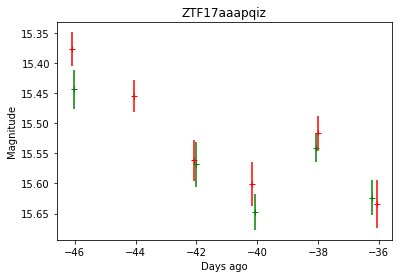

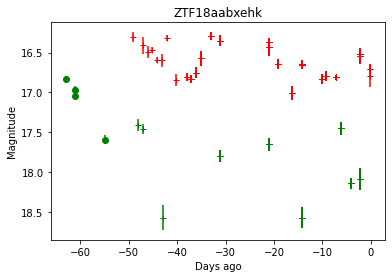

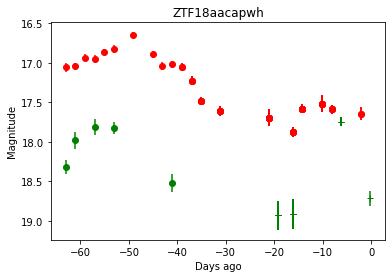

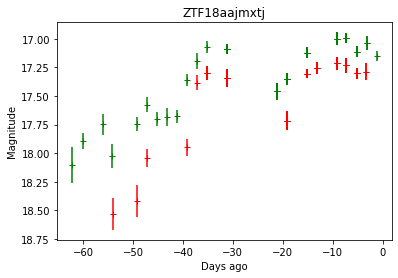

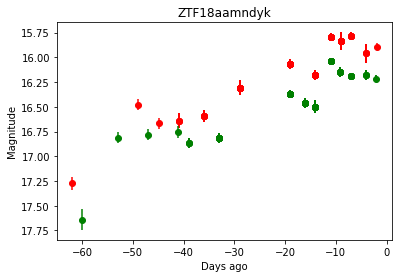

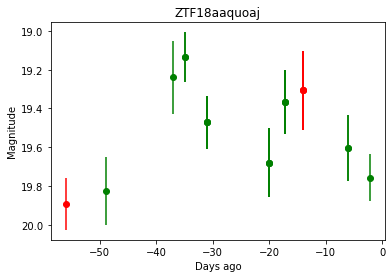

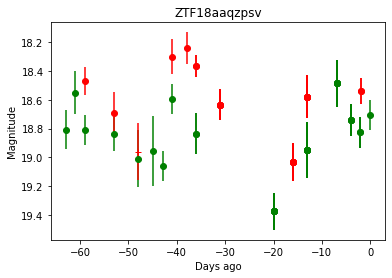

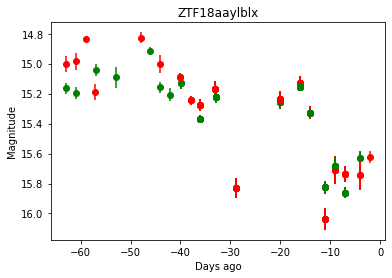

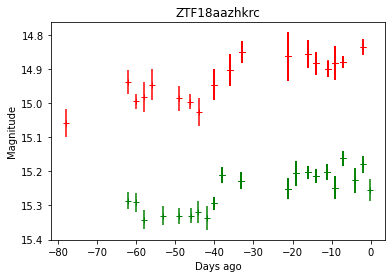

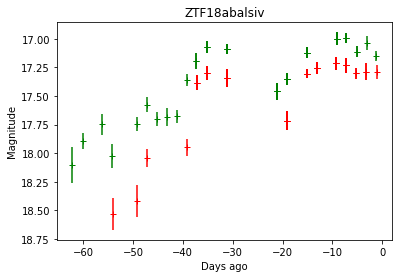

In [63]:
objectList = [row['objectId'] for row in results]
response = L.objects(objectList)

# create an dictionary of lightcurves

lcsDict = {}
for obj in response:    
    lcsDict[obj['objectId']] = {'candidates': obj['candidates']}

cols = {1:'g',2:'r'}

now = Time.now().jd

for obj in response:
        try:
            print ("%s%s" % (obj['TNS']['tns_prefix'], obj['TNS']['tns_name']))
        except KeyError as e:
            print (obj['objectId'], "is not on TNS yet")
        plt.figure()
        plt.subplot(111)
        for i in lcsDict[obj['objectId']]['candidates']:
            if 'isdiffpos' in i:
                if i['isdiffpos']=='t':
                    plt.errorbar(i['jd']-now,i['magpsf'],i['sigmapsf'],fmt='o',color=cols[i['fid']])
                else:
                    plt.errorbar(i['jd']-now,i['magpsf'],i['sigmapsf'],fmt='+',color=cols[i['fid']])

                    
        plt.gca().invert_yaxis()
        plt.ylabel('Magnitude')
        plt.xlabel('Days ago')
        plt.title(obj['objectId'])
